# ASC Domain Siren Demo

make sure to set runtime to GPU!

In [11]:
import zipfile
from torch.hub import download_url_to_file

In [12]:
download_url_to_file('https://github.com/hubtru/ASCDomain/releases/download/demo/demo.zip', '/content/demo.zip')

100%|██████████| 67.9M/67.9M [00:00<00:00, 122MB/s]


In [13]:
!unzip -qq demo.zip

replace demo/audio/airport-barcelona-0-0-0-a.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
!pip install torchinfo

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchinfo
import torchaudio
import time
from torch.utils.data import Dataset as TorchDataset
from sklearn import preprocessing
from torch.utils.data import DataLoader
from torch.distributions.beta import Beta
from IPython.display import Audio, display

In [23]:
use_gpu = True if torch.cuda.is_available() else False
use_gpu

False

## 1) Dataset: DCASE24


In [17]:
class BasicDCASE24Dataset(TorchDataset):
    """
    Basic DCASE'24 Dataset: loads data from files
    """

    def __init__(self, meta_csv):
        """
        @param meta_csv: meta csv file for the dataset
        return: waveform, file, label, device and city
        """
        df = pd.read_csv(meta_csv, sep="\t")
        le = preprocessing.LabelEncoder()
        self.labels = torch.from_numpy(le.fit_transform(df[['scene_label']].values.reshape(-1)))
        self.devices = le.fit_transform(df[['device']].values.reshape(-1))
        self.cities = le.fit_transform(df['cities'].values.reshape(-1))
        self.files = df[['filename']].values.reshape(-1)

    def __getitem__(self, index):
        sig, _ = torchaudio.load(os.path.join('demo', self.files[index]))
        return sig, self.files[index], self.labels[index], self.devices[index], self.cities[index]

    def __len__(self):
        return len(self.files)

class RollDataset(TorchDataset):
    """A dataset implementing time rolling of waveforms.
    """

    def __init__(self, dataset: TorchDataset, shift_range: int, axis=1):
        """
        @param dataset: dataset to load data from
        @param shift_range: maximum shift range
        return: waveform, file, label, device, city
        """
        self.dataset = dataset
        self.shift_range = shift_range
        self.axis = axis

    def __getitem__(self, index):
        x, file, label, device, city = self.dataset[index]
        sf = np.random.randint(-self.shift_range, self.shift_range)
        return x.roll(sf, self.axis), file, label, device, city

    def __len__(self):
        return len(self.dataset)

In [18]:
orig_sample_rate = 44100
roll_sec = 0.1
roll_samples = orig_sample_rate * roll_sec
train_ds = RollDataset(BasicDCASE24Dataset('demo/train_demo.csv'), shift_range=roll_samples)
test_ds = RollDataset(BasicDCASE24Dataset('demo/train_demo.csv'), shift_range=roll_samples)

In [19]:
device_ids = ['a', 'b', 'c', 's1', 's2', 's3', 's4', 's5', 's6']
label_ids = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall',
                          'street_pedestrian', 'street_traffic', 'tram']

Label: airport
Device: a
Shape: torch.Size([1, 44100])


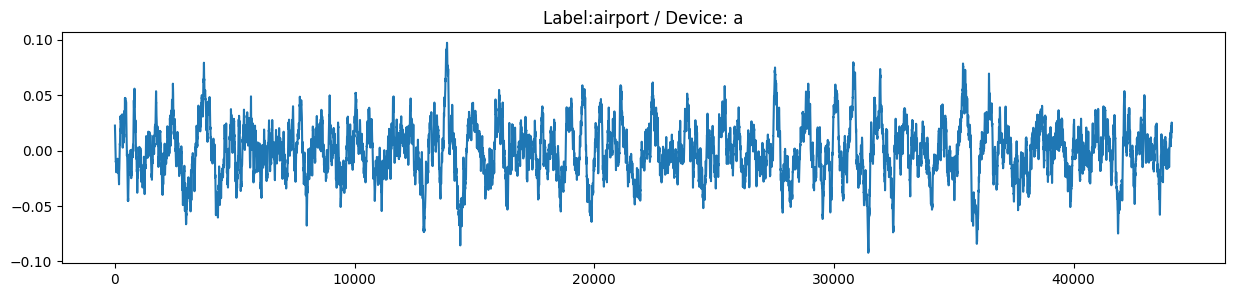

Label: bus
Device: a
Shape: torch.Size([1, 44100])


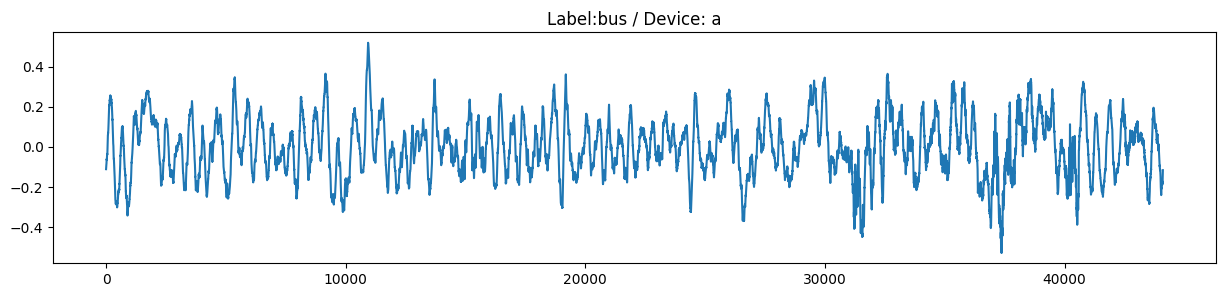

Label: metro
Device: a
Shape: torch.Size([1, 44100])


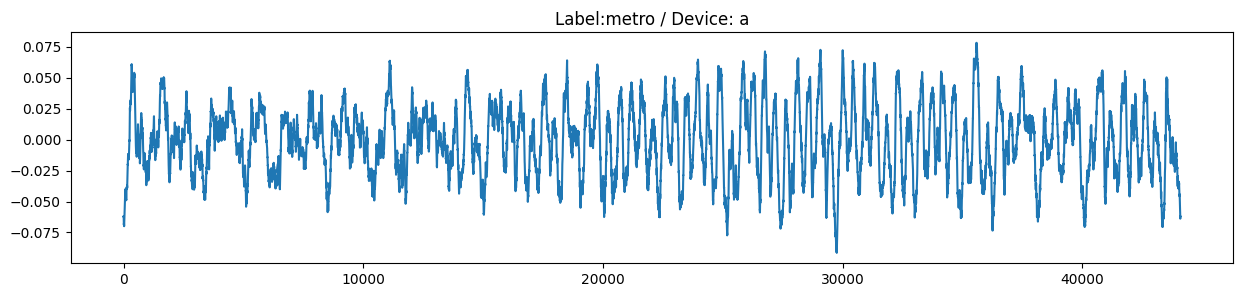

Label: metro_station
Device: a
Shape: torch.Size([1, 44100])


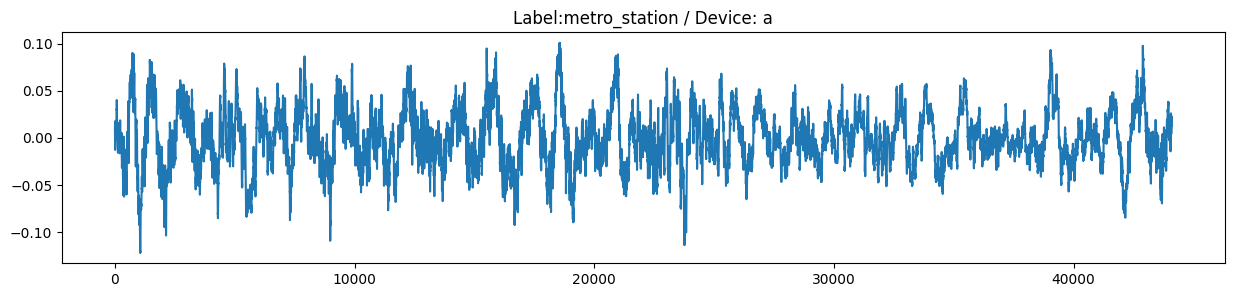

Label: park
Device: a
Shape: torch.Size([1, 44100])


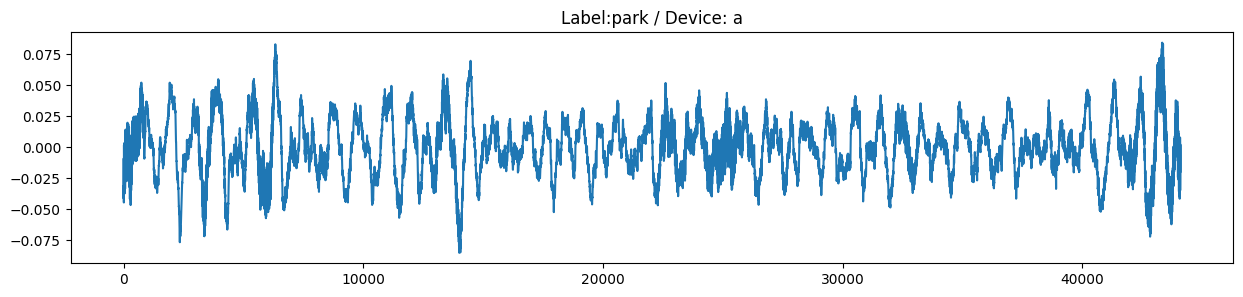

Label: public_square
Device: a
Shape: torch.Size([1, 44100])


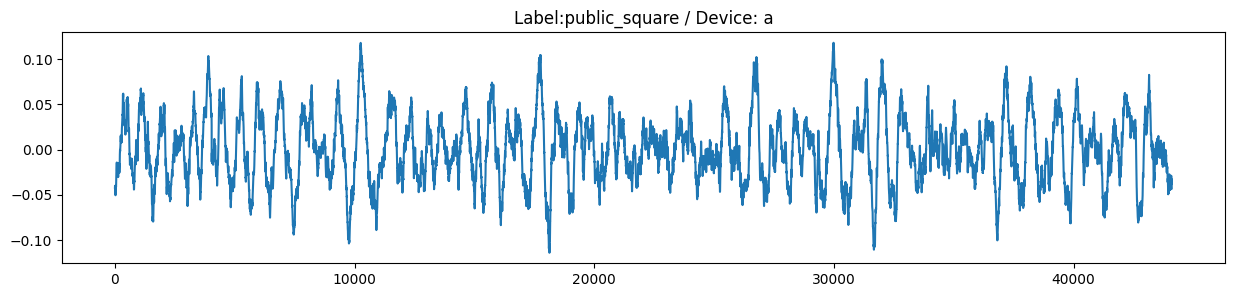

Label: shopping_mall
Device: a
Shape: torch.Size([1, 44100])


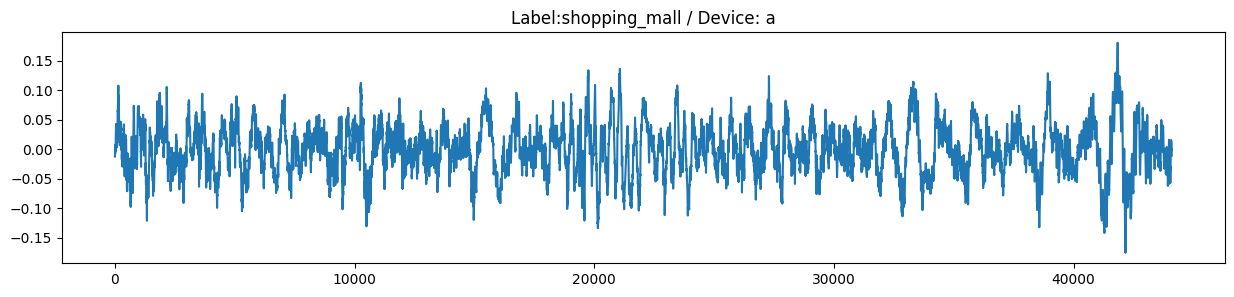

Label: street_pedestrian
Device: a
Shape: torch.Size([1, 44100])


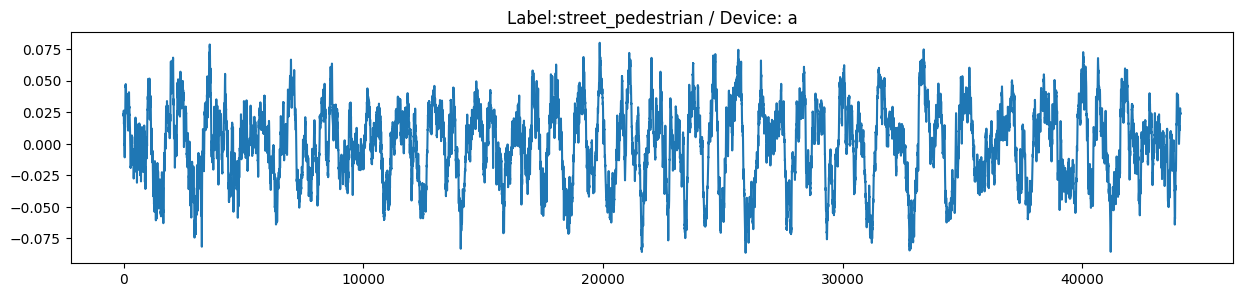

Label: street_traffic
Device: a
Shape: torch.Size([1, 44100])


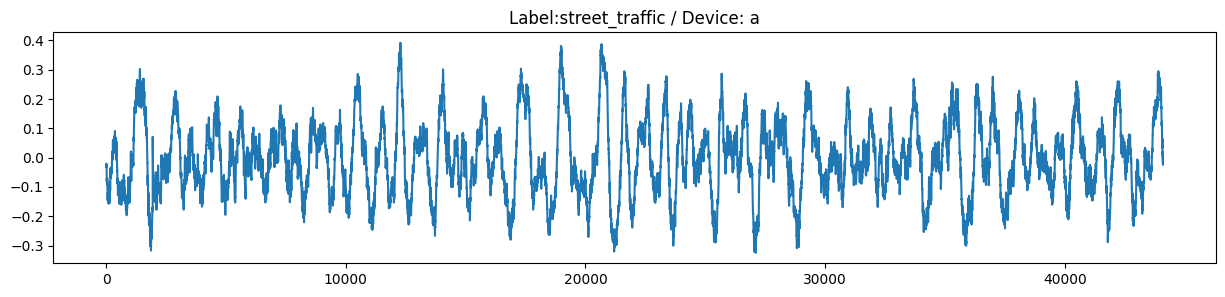

Label: tram
Device: a
Shape: torch.Size([1, 44100])


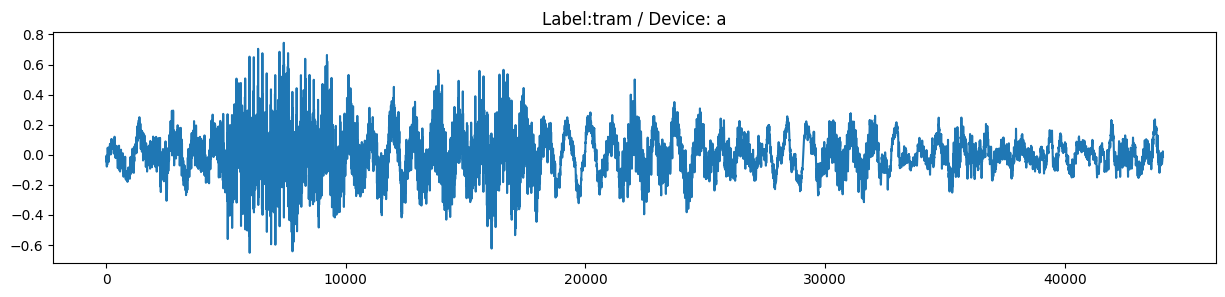

In [20]:
examples = []
examples_ids = [0, 27, 53, 78, 103, 129, 155, 179, 205, 231]
for id in examples_ids:
  x, file, label, device, city = train_ds[id]
  examples.append((x,label,device))
  print('='*150)
  print('Label:', label_ids[label])
  print('Device:', device_ids[device])
  print('Shape:', x.shape)
  plt.figure(figsize=(15,3))
  plt.plot(x.squeeze())
  plt.plot()
  plt.title(f'Label:{label_ids[label]} / Device: {device_ids[device]}')
  plt.show()

## 2) Preprocessing

### 2.1) Resampling

In [21]:
orig_sample_rate = 44100
sample_rate = 32000
resample = torchaudio.transforms.Resample(
    orig_freq=orig_sample_rate,
    new_freq=sample_rate
)

if use_gpu:
    resample.cuda()

In [22]:
exampels_resampled = []
for x, label, device in examples:
  x_res = resample(x.cuda())
  exampels_resampled.append((x_res, label, device))
  print(x_res.shape)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### 2.2) Device Impulse Response Augmentation

In [ ]:
# augment with 3 random device impulse responses
ir_names = ['Altec_639.wav', 'Altec_670A.wav', 'Altec_670B.wav']
augment_p = 0.6 # probability for augmentation

irs = []
for ir_name in ir_names:
    ir,_ = torchaudio.load(os.path.join('demo/impulse_responses', ir_name))
    irs.append(ir)


class DirAugment(nn.Module):
    def __init__(self, augment_p, irs):
        super().__init__()
        self.augment_p = augment_p
        self.irs = irs
        self.conv = torchaudio.transforms.Convolve()

    def forward(self, x, devices=None):
      if devices is None:
        # just for demo
        rnd = np.random.randint(len(self.irs)) # pick a random impulse response
        ir = self.irs[rnd].cuda()
        x = self.conv(x, ir)[:,:sample_rate]
        return x

      idx = np.where(devices.cpu() == 0)[0] # only augment device A which is index 0
      for i in idx:
          if np.random.rand() > augment_p:
              continue

          # augment audio file device impulse response
          rnd = np.random.randint(len(self.irs)) # pick a random impulse response
          if use_gpu:
              ir = self.irs[rnd].cuda()
          else:
              ir = self.irs[rnd]
          x[i] = self.conv(x[i], ir)[:,:sample_rate] # after convolving, the time series is longer, truncate to new_freq
      return x

dir_augment = DirAugment(augment_p, irs)

In [ ]:
examples_augmented = []
for x, label, device in exampels_resampled:
  x_aug = dir_augment(x.cuda()).detach().cpu()
  examples_augmented.append((x_aug, label, device))
  print('='*150)
  print('Label:', label_ids[label])
  print('Device:', device_ids[device])
  print('Shape:', x.shape)

  # play audio
  print('Orginal:')
  display(Audio(data=x.cpu()[0], rate=32000))
  print('Augmented:')
  display(Audio(data=x_aug[0], rate=32000))
  plt.figure(figsize=(15,3))

  # plot
  plt.plot(x.cpu()[0], label='normal')
  plt.plot(x_aug[0], label='augmented', linestyle='-.', alpha=0.8)
  plt.plot()
  plt.title(f'Label:{label_ids[label]} / Device: {device_ids[device]}')
  plt.legend()
  plt.show()

### 2.3) Mel-Spectrogram

In [ ]:
sample_rate = 32000
n_fft = 4096
window_length = 3072
hop_length = 500
n_mels = 256
f_min = 0
f_max = None
mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=window_length,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=f_min,
            f_max=f_max
        )

if use_gpu:
    mel.cuda()

In [ ]:
examples_mel = []
fig = plt.figure(figsize=(9, 8))
columns = 5
rows = 2
ax = []
for i, (x, label, device) in enumerate(examples_augmented):
    x_mel = mel(x.cuda()).detach().cpu()
    x_mel = (x_mel + 1e-5).log()
    examples_mel.append((x_mel, label, device))

    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(label_ids[label])  # set title
    plt.imshow(x_mel[0])
plt.show()



### 2.4) Frequency and Time Masking

In [ ]:
freqm = 48
timem =0

freq_mask = torchaudio.transforms.FrequencyMasking(freqm, iid_masks=True)
time_mask = torchaudio.transforms.TimeMasking(timem, iid_masks=True)

mel_augment = torch.nn.Sequential(
    freq_mask,
    time_mask
)

if use_gpu:
    mel_augment.cuda()

In [ ]:
examples_mask = []
fig = plt.figure(figsize=(9, 8))
columns = 5
rows = 2
ax = []
for i, (x, label, device) in enumerate(examples_mel):
    x_mask = mel_augment(x.cuda()).detach().cpu()
    examples_mask.append((x_mask, label, device))

    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(label_ids[label])  # set title
    plt.imshow(x_mask[0])
plt.show()

### 2.5) Mixstyle

In [ ]:
def mixstyle(x, p=0.4, alpha=0.3, eps=1e-6):
    if np.random.rand() > p:
        return x
    batch_size = x.size(0)
    # original: batch x channel x frequency x time -> mean(frequency, time)
    # freq_style: batch x channel x frequency x time -> mean(channel, time)
    # changed from dim=[2,3] to dim=[1,3] - from channel-wise statistics to frequency-wise statistics
    f_mu = x.mean(dim=[1, 3], keepdim=True)
    f_var = x.var(dim=[1, 3], keepdim=True)

    f_sig = (f_var + eps).sqrt()  # compute instance standard deviation
    f_mu, f_sig = f_mu.detach(), f_sig.detach()  # block gradients
    x_normed = (x - f_mu) / f_sig  # normalize input

    perm = torch.randperm(batch_size).to(x.device)  # generate shuffling indices
    f_mu_perm, f_sig_perm = f_mu[perm], f_sig[perm]  # shuffling

    lmda = Beta(alpha, alpha).sample((batch_size, 1, 1, 1)).to(x.device)  # sample instance-wise convex weights
    mu_mix = f_mu * lmda + f_mu_perm * (1 - lmda)  # generate mixed mean
    sig_mix = f_sig * lmda + f_sig_perm * (1 - lmda)  # generate mixed standard deviation
    x = x_normed * sig_mix + mu_mix  # denormalize input using the mixed frequency statistics
    return x

In [ ]:
examples_data = [x for x, _, _ in examples_mask]
examples_stack = torch.stack(examples_data, dim=0)
examples_mix = mixstyle(examples_stack.cuda(), p=1.0).detach().cpu()

fig = plt.figure(figsize=(9, 8))
columns = 5
rows = 2
ax = []
for i in range(10):
  x_mix = examples_mix[i]
  ax.append( fig.add_subplot(rows, columns, i+1) )
  ax[-1].set_title(label_ids[examples_mask[i][1]])  # set title
  plt.imshow(x_mix[0])

## 3) Isotropic Architecture

In [ ]:
class ActivationBlock(nn.Module):
    def __init__(self, num_features):
        super(ActivationBlock, self).__init__()
        self.activation = nn.GELU()
        self.batch_norm = nn.BatchNorm2d(num_features)

    def forward(self, x):
        x = self.activation(x)
        x = self.batch_norm(x)
        return x


class ConvStem(nn.Module):
    def __init__(self, in_channel, filters, patch_size):
        super(ConvStem, self).__init__()
        self.conv = nn.Conv2d(in_channel, filters, kernel_size=patch_size, stride=patch_size)
        self.activation = ActivationBlock(filters)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class ConvMixerBlock(nn.Module):
    def __init__(self, column, level, filters, kernel_size):
        super(ConvMixerBlock, self).__init__()
        self.column = column
        self.level = level
        self.depthwise_conv = nn.Conv2d(
            filters,
            filters,
            kernel_size=kernel_size,
            padding='same',
            groups=filters,
        )
        self.pointwise_conv = nn.Conv2d(filters, filters, kernel_size=1)
        self.activation_block = ActivationBlock(filters)
        self.activation_block2 = ActivationBlock(filters)

    def reverasable_output_array(self, x, r_arr, column, level):
        r_arr[column][level] = x
        return r_arr

    def forward(self, data):
        x, pe_block, r_arr = data
        if self.column == 0:
            x0 = x
            x = self.depthwise_conv(x)
            x = self.activation_block(x) + x0
            x = self.pointwise_conv(x)
            x = self.activation_block2(x)
            r_arr = self.reverasable_output_array(x, r_arr, self.column, self.level)
            return x, pe_block, r_arr
        else:
            if self.level == 0:
                x0 = r_arr[self.column - 1][self.level + 1] + pe_block
            elif self.level < len(r_arr[0]) - 1 and self.level != 0:
                x0 = r_arr[self.column - 1][self.level + 1] + x
            else:
                x0 = x
            x = self.depthwise_conv(x)
            x = self.activation_block(x) + x0
            x = self.pointwise_conv(x)
            x = self.activation_block2(x)

            if self.column != 0:
                x = r_arr[self.column - 1][self.level] + x

            r_arr = self.reverasable_output_array(x, r_arr, self.column, self.level)
            return x, pe_block, r_arr


class Siren(nn.Module):
    def __init__(
        self, in_channels, filters, depth, columns, kernel_size, patch_size, n_classes
    ):
        super(Siren, self).__init__()
        self.depth = depth
        self.columns = columns
        self.stem = ConvStem(in_channels, filters, patch_size)

        self.mixer_blocks = nn.Sequential()
        for column in range(columns):
            for level in range(depth):
                self.mixer_blocks.add_module(
                    f"block_{column}{level}", ConvMixerBlock(column, level, filters, kernel_size)
                )

        self.classification_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(filters, n_classes),
        )

    def forward(self, x):
        r_arr = [[None for _ in range(self.depth)] for _ in range(self.columns)]
        x = self.stem(x)
        pe_block = x
        x, _, _ = self.mixer_blocks((x, pe_block, r_arr))
        x = self.classification_block(x)
        return x

In [ ]:
# model paramters
in_channels = 1
filter = 64
columns = 3
depth = 3
kernel_size = 3
patch_size = 5
n_classes = 10

siren = Siren(in_channels, filter, columns, depth, kernel_size, patch_size, n_classes)

In [ ]:
torchinfo.summary(siren, input_size=[1,1,256,65])

## 4) Training

In [ ]:
n_epochs = 20
weight_decay = 0.0001
lr = 0.005
optimizer = torch.optim.AdamW(siren.parameters(), lr=lr, weight_decay=weight_decay)
loss_func = nn.CrossEntropyLoss()

In [ ]:
def train(train_dl):
    running_acc = 0.0
    running_loss = 0.0
    running_total = 0.0
    for train_batch in train_dl:
        x, _, labels, devices, _ = train_batch

        if use_gpu:
            # send data to gpu
            x = x.cuda()
            labels = labels.cuda()
            devices = devices.cuda()

        # preprocess
        x = resample(x)
        x = dir_augment(x, devices)
        x = mel(x)
        x = mel_augment(x)
        x = (x + 1e-5).log()
        x = mixstyle(x)

        # featurizer
        y_hat = siren(x)

        # loss
        loss = loss_func(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        predicted = y_hat.argmax(1)
        running_total += len(labels)
        running_acc += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dl)
    train_acc = 100 * running_acc / running_total
    return train_loss, train_acc

In [ ]:
def eval(test_dl):
    running_acc = 0.0
    running_loss = 0.0
    running_total = 0.0
    with torch.no_grad():
        for test_batch in test_dl:
            x, _, labels, _, _ = test_batch

            if use_gpu:
                # send data to gpu
                x = x.cuda()
                labels = labels.cuda()

            # preprocess
            x = resample(x)
            x = mel(x)
            x = (x + 1e-5).log()

            # featurizer
            y_hat = siren(x)

            # loss
            loss = loss_func(y_hat, labels)

            # statistics
            running_loss += loss.item()
            predicted = y_hat.argmax(1)
            running_total += len(labels)
            running_acc += (predicted == labels).sum().item()

    val_loss = running_loss / len(test_dl)
    val_acc = 100 * running_acc / running_total
    return val_loss, val_acc

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
# training loop
stats = {
        'train_loss': [],
        'train_acc' : [],
        'val_loss'  : [],
        'val_acc'   : [],
        }
start_time = time.time()
for i in range(n_epochs):

    train_loss, train_acc = train(train_dl)
    val_loss, val_acc = eval(test_dl)
    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    stats['val_loss'].append(val_loss)
    stats['val_acc'].append(val_acc)

    print(f'Epoch {i+1}/{n_epochs}\tloss: {round(train_loss, 2)}\tacc: {round(train_acc, 2)} %\tval_loss: {round(val_loss,2)}\tval_accuracy: {round(val_acc,2)} %')
end_time = time.time()
test_loss, test_acc = eval(test_dl)
print(f'Test loss: {round(test_loss,2)}\t Test acc: {round(test_acc,2)}')
print(f'Training Time: {round((end_time-start_time)/60, 2)} min')

In [ ]:
plt.plot(stats['train_loss'], label='train')
plt.plot(stats['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(stats['train_acc'], label='train')
plt.plot(stats['val_acc'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Acc (%)')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()